# Adapter Tuning Gemma

We will fine-tune Gemma to caption images using HuggingFace Transformers and QLoRA

Based on https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora

In [1]:
#%pip install --upgrade --quiet "torch>=2.4.0" tensorboard torchvision transformers datasets accelerate evaluate bitsandbytes trl peft pillow protobuf sentencepiece

You will need to set the HF_TOKEN in keys.env
and accept the Gemma license on http://huggingface.co/google/gemma-3-4b-pt

In [2]:
import os
from dotenv import load_dotenv
load_dotenv("../keys.env")
assert os.environ["HF_TOKEN"][:2] == "hf",\
       "Please specify the HuggingFace access token in keys.env file"

## Read in messages.jsonl

In [3]:
import json
def read_messages(filename="messages.jsonl"):
    with open(filename, "r") as ifp:
        return [json.loads(line) for line in ifp.readlines()]

messages = read_messages()
messages[:3]

[{'messages': [{'role': 'system',
    'content': [{'type': 'text',
      'text': 'You are an expert researcher in radiology.'}]},
   {'role': 'user',
    'content': [{'type': 'text',
      'text': 'Write a caption for this image explaining what it depicts, suitable for use in a research publication.'},
     {'type': 'image',
      'image': 'all_data/train/radiology/images/PMC4083729_AMHSR-4-14-g002.jpg'}]},
   {'role': 'assistant',
    'content': [{'type': 'text',
      'text': 'Computed tomography scan in axial view showing obliteration of the left maxillary sinus'}]}]},
 {'messages': [{'role': 'system',
    'content': [{'type': 'text',
      'text': 'You are an expert researcher in radiology.'}]},
   {'role': 'user',
    'content': [{'type': 'text',
      'text': 'Write a caption for this image explaining what it depicts, suitable for use in a research publication.'},
     {'type': 'image',
      'image': 'all_data/train/radiology/images/PMC2837471_IJD2009-150251.001.jpg'}]},
   {'ro

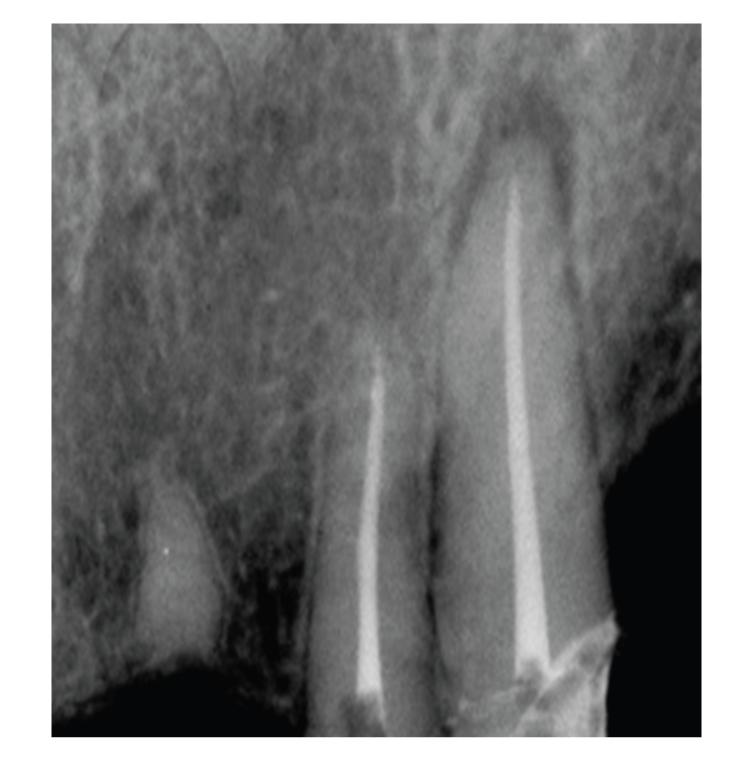

In [4]:
from IPython.display import Image as showImage
showImage(filename='all_data/train/radiology/images/PMC2837471_IJD2009-150251.001.jpg')

In [10]:
# read image in as Pillow
from PIL import Image
def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(Image.open(image).convert("RGB"))
    return image_inputs

process_vision_info(messages[1]['messages'])

[<PIL.Image.Image image mode=RGB size=745x763>]

## Load Gemma model

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

# Hugging Face model id
model_id = "google/gemma-3-4b-pt" # or `google/gemma-3-12b-pt`, `google/gemma-3-27-pt`

# Check if GPU benefits from bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

# Define model init arguments
model_kwargs = dict(
    attn_implementation="eager", # Use "flash_attention_2" when running on Ampere or newer GPU
    torch_dtype=torch.bfloat16, # What torch dtype to use, defaults to auto
    device_map="auto", # Let torch decide how to load the model
)

# BitsAndBytesConfig int-4 config
model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

# Load model and tokenizer
model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it")

## Use QLoRA to efficiently tune Gemma

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [ ]:
from trl import SFTConfig

args = SFTConfig(
    output_dir="gemma-product-description",     # directory to save and repository id
    num_train_epochs=1,                         # number of training epochs
    per_device_train_batch_size=1,              # batch size per device during training
    gradient_accumulation_steps=4,              # number of steps before performing a backward/update pass
    gradient_checkpointing=True,                # use gradient checkpointing to save memory
    optim="adamw_torch_fused",                  # use fused adamw optimizer
    logging_steps=5,                            # log every 5 steps
    save_strategy="epoch",                      # save checkpoint every epoch
    learning_rate=2e-4,                         # learning rate, based on QLoRA paper
    bf16=True,                                  # use bfloat16 precision
    max_grad_norm=0.3,                          # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                          # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",               # use constant learning rate scheduler
    push_to_hub=True,                           # push model to hub
    report_to="tensorboard",                    # report metrics to tensorboard
    gradient_checkpointing_kwargs={
        "use_reentrant": False
    },  # use reentrant checkpointing
    dataset_text_field="",                      # need a dummy field for collator
    dataset_kwargs={"skip_prepare_dataset": True},  # important for collator
)
args.remove_unused_columns = False # important for collator

# Create a data collator to encode text and image pairs
def collate_fn(examples):
    texts = []
    images = []
    for example in examples:
        image_inputs = process_vision_info(example["messages"])
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        texts.append(text.strip())
        images.append(image_inputs)

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens and image tokens in the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

## Start training

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

In [ ]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

## Test model

In [8]:
!head -5 all_data/test/radiology/testdata.csv

id,name,caption
ROCO_00001,PMC4608653_cro-0008-0385-g01.jpg," Axial MRI (coronal view).
"
ROCO_00006,PMC4840839_ol-11-05-3298-g02.jpg," Coronal plain computed tomography image showing multiple large tumor masses with edge enhancement inside the abdominal cavity and liver.
"


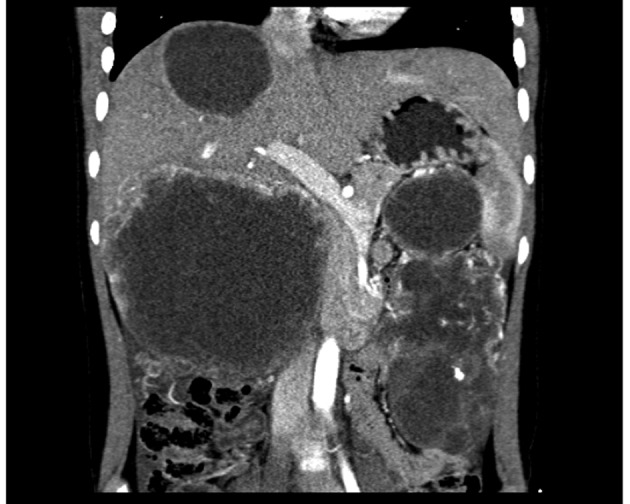

In [9]:
TEST_IMAGE='all_data/test/radiology/images/PMC4840839_ol-11-05-3298-g02.jpg'
from IPython.display import Image as showImage
showImage(filename=TEST_IMAGE)

In [ ]:
## This is optional; you can keep the adapter weights separate and use both
def merge_models():
    from peft import PeftModel

    # Load Model base model
    model = AutoModelForImageTextToText.from_pretrained(model_id, low_cpu_mem_usage=True)

    # Merge LoRA and base model and save
    peft_model = PeftModel.from_pretrained(model, args.output_dir)
    merged_model = peft_model.merge_and_unload()
    merged_model.save_pretrained("merged_model", safe_serialization=True, max_shard_size="2GB")

    processor = AutoProcessor.from_pretrained(args.output_dir)
    processor.save_pretrained("merged_model")

In [ ]:
import torch

# Load Model with PEFT adapter (not the merged model)
model = AutoModelForImageTextToText.from_pretrained(
  args.output_dir,
  device_map="auto",
  torch_dtype=torch.bfloat16,
  attn_implementation="eager",
)
processor = AutoProcessor.from_pretrained(args.output_dir)

In [ ]:
## Similar to 1_prepare_data.ipynb, except that there is no assistant message (the output)
def format_message(image_filename):
    system_message = "You are an expert researcher in radiology."
    user_prompt = "Write a caption for this image explaining what it depicts, suitable for use in a research publication."
    return {
        "messages": [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": user_prompt,
                    },
                    {
                        "type": "image",
                        "image": image_filename
                    },
                ],
            },
        ],
    }

In [ ]:
import requests
from PIL import Image

def generate_description(image_filename, model, processor):
    # Convert sample into messages and then apply the chat template
    messages = format_message(image_filename)
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages) # will read into Pillow
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)
    
    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
description = generate_description(TEST_IMAGE, model, processor)
print(description)